<a href="https://colab.research.google.com/github/9characters/ML-projects/blob/main/Data_preprocessing_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lab 2: Loading and Understanding Your Data
** Learning Objectives **
* Learn the basics of reading data, data cleaning and handling missing data using Pandas.
* Learn how to visualize data with a scatter plot.
* Use Numpy to generate the line minimizing squared loss.
* Explore visually the difference in the model when replacing missing items by 0s versus the mean value for that feature.

### Imports
In this first cell, we'll import some libraries, including  [Pandas](http://pandas.pydata.org/), which is a package we use for reading in our data, exploring our data and doing some basic processing. Run this cell to execute the code.

In [ ]:
import fnmatch
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
print("Done with the imports.")

Done with the imports.


### Set up Pandas Options

Next we set up some options to control how items are displayed and the maximum number of rows to show when displaying a table.  Feel free to change this setup to whatever you'd like.

As illustrated below, in colab you can define code cells that do not generate any output. In fact, the first cell would also have been that way except for the `print` statement at the end added just to help illustrate this aspect of colab. If at any point you are not sure if a cell is successfully running, you can add a print statement, but that should not be necessary since you can visually see when the cell is done running when the arrow is showing again. Also note that when you select the next cell the number showing the execution order of the cell appears.

In [ ]:
# Set the output display to have two digits for decimal places, for display
# readability only and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Data Set
This lab will use a data set from 1985 Ward's Automotive Yearbook that is part of the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets) under [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile).  You can find a description of the data at [https://archive.ics.uci.edu/ml/datasets/automobile](https://archive.ics.uci.edu/ml/datasets/automobile).  Since this data set is provided as a comma separated file without a header row, we provide column headers when loading it with Pandas.

### Loading and Randomizing the Data
Load the data using the column names from [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile). When using SGD (stochastic graident descent) for training it is important that **each batch is a random sample of the data** so that the gradient computed is representative.  While there appears to be no order to this data set, it is always good practice to shuffle the data to be in a random order.


In [ ]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
cols = ['symboling', 'losses', 'make', 'fuel-type', 'aspiration', 'num-doors',
        'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-type', 'num-cylinders',
        'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']


# Load in the data from a CSV file that is comma seperated.
car_data = pd.read_csv('https://storage.googleapis.com/ml_universities/cars_dataset/cars_data.csv',
                        sep=',', names=cols, header=None, encoding='latin-1')

# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

### Examine the Data

It's a good idea to get to know your data a little bit before you work with it. Let's look at the header row and the first 10 rows of data.


In [ ]:
car_data[1:10]

,symboling,losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,weight,engine-type,num-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
66,0,?,mazda,diesel,std,four,sedan,rwd,front,104.90,175.00,66.10,54.40,2700,ohc,four,134,idi,3.43,3.64,22.00,72,4200,31,39,18344
47,0,145,jaguar,gas,std,four,sedan,rwd,front,113.00,199.60,69.60,52.80,4066,dohc,six,258,mpfi,3.63,4.17,8.10,176,4750,15,19,32250
12,0,188,bmw,gas,std,two,sedan,rwd,front,101.20,176.80,64.80,54.30,2710,ohc,six,164,mpfi,3.31,3.19,9.00,121,4250,21,28,20970
181,-1,?,toyota,gas,std,four,wagon,rwd,front,104.50,187.80,66.50,54.10,3151,dohc,six,161,mpfi,3.27,3.35,9.20,156,5200,19,24,15750
62,0,115,mazda,gas,std,four,sedan,fwd,front,98.80,177.80,66.50,55.50,2410,ohc,four,122,2bbl,3.39,3.39,8.60,84,4800,26,32,10245
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.60,168.80,64.10,48.80,2548,dohc,four,130,mpfi,3.47,2.68,9.00,111,5000,21,27,13495
132,3,150,saab,gas,std,two,hatchback,fwd,front,99.10,186.60,66.50,56.10,2658,ohc,four,121,mpfi,3.54,3.07,9.31,110,5250,21,28,11850
95,1,128,nissan,gas,std,two,hatchback,fwd,front,94.50,165.60,63.80,53.30,2028,ohc,four,97,2bbl,3.15,3.29,9.40,69,5200,31,37,7799
89,1,128,nissan,gas,std,two,sedan,fwd,front,94.50,165.30,63.80,54.50,1889,ohc,four,97,2bbl,3.15,3.29,9.40,69,5200,31,37,5499


### Look at Some Basic Statistics About the Data
We'll print out a quick summary of a few useful statistics on each column. This will include things like mean, standard deviation, max, min, and various quantiles.

In [ ]:
car_data.describe()

,symboling,wheel-base,length,width,height,weight,engine-size,compression-ratio,city-mpg,highway-mpg
count,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00
mean,0.83,98.76,174.05,65.91,53.72,2555.57,126.91,10.14,25.22,30.75
std,1.25,6.02,12.34,2.15,2.44,520.68,41.64,3.97,6.54,6.89
min,-2.00,86.60,141.10,60.30,47.80,1488.00,61.00,7.00,13.00,16.00
25%,0.00,94.50,166.30,64.10,52.00,2145.00,97.00,8.60,19.00,25.00
50%,1.00,97.00,173.20,65.50,54.10,2414.00,120.00,9.00,24.00,30.00
75%,2.00,102.40,183.10,66.90,55.50,2935.00,141.00,9.40,30.00,34.00
max,3.00,120.90,208.10,72.30,59.80,4066.00,326.00,23.00,49.00,54.00


### Handling Missing Data Entries
Why are some columns such as the price and losses not showing in the summary column?  If we look at the data more carefuly, we'll see that a "?" was used in this data set to indicate that a value is unknown.

Pandas provices a method [to_numeric](http://pandas.pydata.org/pandas-docs/version/0.18.1/generated/pandas.to_numeric.html) that converts a column to be numeric. There are three options about how to handle errors (entries that are not numeric) of which 'coerce' is what we want to use in this situation, since it converts those entries to pandas representation `NaN` for "not a number".

Notice now when you use `describe` to see the statistics for the entries that are a number, the count indicates how many entries had a number (not `NaN`) for that column.

In [ ]:
car_data['price'] = pd.to_numeric(car_data['price'], errors='coerce')
car_data['horsepower'] = pd.to_numeric(car_data['horsepower'], errors='coerce')
car_data['peak-rpm'] = pd.to_numeric(car_data['peak-rpm'], errors='coerce')
car_data['city-mpg'] = pd.to_numeric(car_data['city-mpg'], errors='coerce')
car_data['highway-mpg'] = pd.to_numeric(car_data['highway-mpg'], errors='coerce')
car_data['losses'] = pd.to_numeric(car_data['losses'], errors='coerce')
car_data.describe()

,symboling,losses,wheel-base,length,width,height,weight,engine-size,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,205.00,164.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,203.00,203.00,205.00,205.00,201.00
mean,0.83,122.00,98.76,174.05,65.91,53.72,2555.57,126.91,10.14,104.26,5125.37,25.22,30.75,13207.13
std,1.25,35.44,6.02,12.34,2.15,2.44,520.68,41.64,3.97,39.71,479.33,6.54,6.89,7947.07
min,-2.00,65.00,86.60,141.10,60.30,47.80,1488.00,61.00,7.00,48.00,4150.00,13.00,16.00,5118.00
25%,0.00,94.00,94.50,166.30,64.10,52.00,2145.00,97.00,8.60,70.00,4800.00,19.00,25.00,7775.00
50%,1.00,115.00,97.00,173.20,65.50,54.10,2414.00,120.00,9.00,95.00,5200.00,24.00,30.00,10295.00
75%,2.00,150.00,102.40,183.10,66.90,55.50,2935.00,141.00,9.40,116.00,5500.00,30.00,34.00,16500.00
max,3.00,256.00,120.90,208.10,72.30,59.80,4066.00,326.00,23.00,288.00,6600.00,49.00,54.00,45400.00


### Replacing NAN by zero
When training a linear model using features that is numerical, we **cannot have `NaN` (doing so would cause overflow when training)**. Here we replace `NaN` (which corresponding to where we had missing entries) by 0.

In [ ]:
# Replace nan by 0 storing the solution in the same table (`inplace')
car_data.fillna(0, inplace=True)
car_data.describe()

,symboling,losses,wheel-base,length,width,height,weight,engine-size,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00
mean,0.83,97.60,98.76,174.05,65.91,53.72,2555.57,126.91,10.14,103.24,5075.37,25.22,30.75,12949.43
std,1.25,58.28,6.02,12.34,2.15,2.44,520.68,41.64,3.97,40.83,694.65,6.54,6.89,8079.04
min,-2.00,0.00,86.60,141.10,60.30,47.80,1488.00,61.00,7.00,0.00,0.00,13.00,16.00,0.00
25%,0.00,77.00,94.50,166.30,64.10,52.00,2145.00,97.00,8.60,70.00,4800.00,19.00,25.00,7689.00
50%,1.00,103.00,97.00,173.20,65.50,54.10,2414.00,120.00,9.00,95.00,5200.00,24.00,30.00,10198.00
75%,2.00,137.00,102.40,183.10,66.90,55.50,2935.00,141.00,9.40,116.00,5500.00,30.00,34.00,16500.00
max,3.00,256.00,120.90,208.10,72.30,59.80,4066.00,326.00,23.00,288.00,6600.00,49.00,54.00,45400.00


### Using a Scatter Plot to Visualize the Data

We will begin by trying to predict the price using the horsepower.  Because we just have a single feature we can visualize the raw data using a scatter plot.

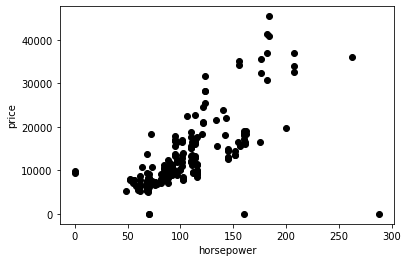

In [ ]:
INPUT_FEATURE = "horsepower"
LABEL = "price"

plt.ylabel(LABEL)
plt.xlabel(INPUT_FEATURE)
plt.scatter(car_data[INPUT_FEATURE], car_data[LABEL], c='black')
plt.show()

###Using Numpy polyfit to Find the Line that Minimizes RMSE
For the task of finding a line that minimizes the squared error with respect to a set of points, using SGD is not the most efficient method but it will be useful in that it can be applied to much more complex problems.  As a tool to help see what the optimal solution looks like we wil use `polyfit` to compute the optimal solution and then add that to our plot.

In [ ]:
x = car_data[INPUT_FEATURE]
y = car_data[LABEL]
opt = np.polyfit(x, y, 1)
y_pred = opt[0] * x + opt[1]
opt_rmse = math.sqrt(metrics.mean_squared_error(y_pred, y))
slope = opt[0]
bias = opt[1]
print("Optimal RMSE =", opt_rmse, "for solution", opt)

Optimal RMSE = 5823.494869419034 for solution [  136.77704681 -1171.29960347]


###Visualizing a Linear Model Using a Scatter Plot

When training a linear regression model over a single variable, a really nice thing to be able to do is to show the model (which is just a line) as part of the scatter plot. That really helps you see how well the model fits the data. Just looking at the loss (RMSE here) doesn't really indicate how good the model is. Sometimes you want to show several models on the same scatter plot to compare them so we allow slopes, biases, and model_names to all be lists. They should be of the same size giving the weight (slope), bias, and name (to use in the legend) for the model.

In [ ]:
def scatter_plot(features, targets, slopes=[], biases=[], model_names=[]):
  """ Creates a scatter plot of input_feature vs target along with the models.
  
  Args:
    features: list of the input features
    targets: list of targets
    slopes: list of model weight (slope) 
    bias: list of model bias (same size as slopes)
    model_names: list of model_names to use for legend (same size as slopes)
  """      
  # Define some colors to use that go from blue towards red
  colors = [cm.coolwarm(x) for x in np.linspace(0, 1, len(slopes))]
  
  # Generate the Scatter plot
  plt.ylabel("target")
  plt.xlabel("input feature")
  plt.scatter(features, targets, color='black', label="")
  
  # Add the lines corresponding to the provided models
  for i in range (0, len(slopes)):
    y_0 = slopes[i] * features.min() + biases[i]
    y_1 = slopes[i] * features.max() + biases[i]
    plt.plot([features.min(), features.max()], [y_0, y_1],
             label=model_names[i], color=colors[i])
  if (len(model_names) > 0):
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

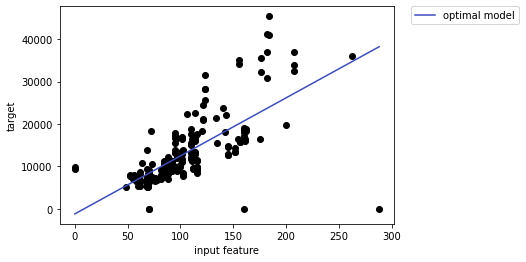

In [ ]:
scatter_plot(car_data[INPUT_FEATURE], car_data[LABEL],
             [slope], [bias], ["optimal model"])

## Exercise: Create a Scatter Plot for Different Features (1 Point)

Create a scatter plot with price as the input feature and losses as the label where the line optimizing the squared loss is shown.  We've gotten you started.  You just need to copy the appropriate lines from above.  **Save the slope and bias from this line to be used in a later exercise.**

Slope: -0.0017164908142835056
Bias: 119.82757638923837
RMSE: 56.46997356440865


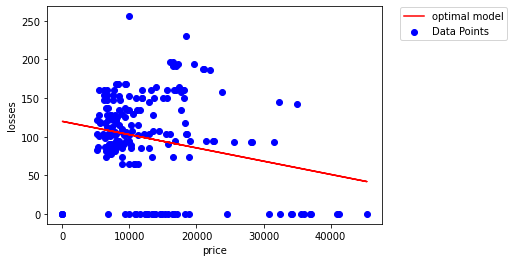

In [ ]:
INPUT_FEATURE = "price"
LABEL = "losses"

# Fill in the rest of this blocks

# Fitting the input features to the label to get the slope and bias
X_0 = car_data[INPUT_FEATURE]
y_0 = car_data[LABEL]
result = np.polyfit(X_0, y_0, 1)
slope_0 = result[0]
bias_0 = result[1]
print(f"Slope: {slope_0}")
print(f"Bias: {bias_0}")

# Calculating the RMSE value
y_pred = (slope_0 * X_0) + bias_0
rmse_0 = math.sqrt(metrics.mean_squared_error(y_pred, y_0))
print(f"RMSE: {rmse_0}")

# Making scatter plot and the linear line
plt.xlabel(INPUT_FEATURE)
plt.ylabel(LABEL)
plt.scatter(X_0, y_0, c="blue", label="Data Points")
plt.plot(X_0, (slope_0 * X_0) + bias_0, c = "red", label="optimal model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
plt.show()

## Exercise: Explain what you see (1 point)


In [ ]:
"""
Explain why you are seeing so many points along the line y=0.

TYPE YOUR ANSWER IN THIS COMMENT

Answer:
There are so many points along the line y=0, because in the above code we 
replaced the missing NAN values by 0 using the method "fillna()".

"""

'\nExplain why you are seeing so many points along the line y=0.\n\nTYPE YOUR ANSWER IN THIS COMMENT\n\nAnswer:\nThere are so many points along the line y=0, because in the above code we \nreplaced the missing NAN values by 0 using the method "fillna()".\n\n'

##Exercise: Explore Options to Handle Missing Data 

In this exercise you will explore alternate ways to handle missing data. When training a linear model using features that are numerical, we **cannot have `NaN` (doing so would cause overflow when training)**. One option is to just discard any rows with any missing entries but often this would not leave enough data.  Here we explore ways to handle the missing data without just discarding it.

Note that when you get a column of a dataframe (e.g. car_data["price']), you get a `Series`.  Read [http://pandas.pydata.org/pandas-docs/version/0.18.1/api.html#computations-descriptive-stats](http://pandas.pydata.org/pandas-docs/version/0.18.1/api.html#computations-descriptive-stats) and think about if you see any statistics for a column that might make a better choice than 0 for filling in the missing entries.What do you think would work best?

Modify the code to use the function you selected to replace missing data instead of just using 0. Look at both the scatter plots and the lines minimizing RMSEs of both outputs. Feel free to show multiple options as a tool to help you explain your choice of which you think is best. What option do you think is best and why?


In [ ]:
# Load in the data from a CSV file that is comma seperated.
car_data_v2 = pd.read_csv('https://storage.googleapis.com/ml_universities/cars_dataset/cars_data.csv',
                           sep=',', names=cols, header=None, encoding='latin-1')
for col in cols:
  car_data_v2[col] = pd.to_numeric(car_data_v2[col], errors="coerce")

In [ ]:
# Fill in what you want to do with the nan here

Unlike replacing with 0, I will be using 3 other approaches, and evaluate the result using RMSE, and finally conclude with my argument for selecting the specific approach.

The approaches are:
1. Replacing with the mean value
2. Replacing with the median value
2. Interpolating the values with respect to neighbouring values
3. Using the highly correlated another feature from the dataset, to fill out the NaN values

In [ ]:
INPUT_FEATURE = "price"
LABEL = "losses"

In [ ]:
# 1st APPROACH: Replacing NaN with the mean value

car_data_v2_mean = car_data_v2.copy()

# Filling the NaN values with the mean value of column
car_data_v2_mean = car_data_v2_mean.fillna(car_data_v2_mean.mean())

# Now, we perform the Linear Regression using our INPUT_FEATURE and the LABEL
X_av = car_data_v2_mean[INPUT_FEATURE]
y_av = car_data_v2_mean[LABEL]
slope_av, bias_av = np.polyfit(X_av, y_av, 1)
print(f"Slope: {slope_av}\nBias: {bias_av}")
y_pred = (slope_av * X_av) + y_av
rmse_av = math.sqrt(metrics.mean_squared_error(y_pred, y_av))
print("RMSE:", rmse_av)

Slope: 0.0005395018473724521
Bias: 114.87472931544343
RMSE: 8.288752689646977


In [ ]:
# 2st APPROACH: Replacing NaN with the median of "losses"

car_data_v2_med = car_data_v2.copy()

# Filling the NaN values with the median of the columns
car_data_v2_med = car_data_v2_med.fillna(car_data_v2_med.median())

# Now, we perform the Linear Regression using our INPUT_FEATURE and the LABEL
X_med = car_data_v2_med[INPUT_FEATURE]
y_med = car_data_v2_med[LABEL]
slope_med, bias_med = np.polyfit(X_med, y_med, 1)
print(f"Slope: {slope_med}\nBias: {bias_med}")
y_pred = (slope_med * X_med) + y_med
rmse_med = math.sqrt(metrics.mean_squared_error(y_pred, y_med))
print("RMSE:", rmse_med)

Slope: 0.0003854535992749306
Bias: 115.5311667130627
RMSE: 5.90522340615014


In [ ]:
# 3rd APPROACH: Interpolating the values with respect to neighbouring values

car_data_v2_int = car_data_v2.copy()

# Now, we drop the rows with NaN value in INPUT_FEATURE
car_data_v2_int = car_data_v2_int.dropna(subset=[INPUT_FEATURE])

# Taking only the two columns and sorting them based on independent variable
car_data_v2_int = car_data_v2_int[[INPUT_FEATURE, LABEL]].sort_values(by="price")

# Interpolating the values
car_data_v2_int = car_data_v2_int.interpolate(method="linear")

# Now, we perform the Linear Regression using our INPUT_FEATURE and the LABEL
X_int = car_data_v2_int[INPUT_FEATURE]
y_int = car_data_v2_int[LABEL]
slope_int, bias_int = np.polyfit(X_int, y_int, 1)
print(f"Slope: {slope_int}\nBias: {bias_int}")
y_pred = (slope_int * X_int) + y_int
rmse_int = math.sqrt(metrics.mean_squared_error(y_pred, y_int))
print("RMSE:", rmse_int)

Slope: 0.0009359459457233923
Bias: 110.89008460829089
RMSE: 14.41690743821917


In [ ]:
car_data_v2_corr = car_data_v2.copy()
car_data_v2_corr

,symboling,losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,weight,engine-type,num-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,nan,nan,nan,nan,nan,nan,nan,nan,88.60,168.80,64.10,48.80,2548,nan,nan,130,nan,3.47,2.68,9.00,111.00,5000.00,21,27,13495.00
1,3,nan,nan,nan,nan,nan,nan,nan,nan,88.60,168.80,64.10,48.80,2548,nan,nan,130,nan,3.47,2.68,9.00,111.00,5000.00,21,27,16500.00
2,1,nan,nan,nan,nan,nan,nan,nan,nan,94.50,171.20,65.50,52.40,2823,nan,nan,152,nan,2.68,3.47,9.00,154.00,5000.00,19,26,16500.00
3,2,164.00,nan,nan,nan,nan,nan,nan,nan,99.80,176.60,66.20,54.30,2337,nan,nan,109,nan,3.19,3.40,10.00,102.00,5500.00,24,30,13950.00
4,2,164.00,nan,nan,nan,nan,nan,nan,nan,99.40,176.60,66.40,54.30,2824,nan,nan,136,nan,3.19,3.40,8.00,115.00,5500.00,18,22,17450.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95.00,nan,nan,nan,nan,nan,nan,nan,109.10,188.80,68.90,55.50,2952,nan,nan,141,nan,3.78,3.15,9.50,114.00,5400.00,23,28,16845.00
201,-1,95.00,nan,nan,nan,nan,nan,nan,nan,109.10,188.80,68.80,55.50,3049,nan,nan,141,nan,3.78,3.15,8.70,160.00,5300.00,19,25,19045.00
202,-1,95.00,nan,nan,nan,nan,nan,nan,nan,109.10,188.80,68.90,55.50,3012,nan,nan,173,nan,3.58,2.87,8.80,134.00,5500.00,18,23,21485.00
203,-1,95.00,nan,nan,nan,nan,nan,nan,nan,109.10,188.80,68.90,55.50,3217,nan,nan,145,nan,3.01,3.40,23.00,106.00,4800.00,26,27,22470.00


In [ ]:
# 4th APPROACH: 
# * Using the highly correlated another feature from the dataset
# * Finding out the slope and bias using that feature
# * Filling the NaN values using the observed slope and bias

######### CHECKING CORRELATIOIN ##########################################

# Features to check the correlation with "losses"
corr_check_cols = ["horsepower", "peak-rpm", "city-mpg", "highway-mpg"]

car_data_v2_corr = car_data_v2.copy().dropna(subset=corr_check_cols)

def check_correlation(required_cols):
  """
  params:
    required_cols: list
    + Columns (or features) to evaluate the correlation with "losses"
  
  returns:
    best_corr_col: str
    + Name of the column (feature) with high correlation with "losses"
  """
  var1 = car_data_v2_corr["losses"]
  corr_dict = dict()
  for column in required_cols:
    var2 = car_data_v2_corr[column]
    r = var1.corr(var2)   # Pearson's Correlation
    print(f"The Correletaion Coefficient between losses and {column} is: {r}.")
    corr_dict[column] = 1 - abs(r)
  best_corr_col = min(corr_dict, key=corr_dict.get)
  print(f"The best correlation of 'losses' is with '{best_corr_col}'") 
  return best_corr_col

best_corr_col = check_correlation(corr_check_cols)
###########################################################################

# Now taking only the highly correlated feature, "price" and "losses"
df = car_data_v2[[best_corr_col] + ["price", "losses"]].dropna(
                                subset=[best_corr_col]).reset_index(drop=True)
temp_cols = df.copy().dropna(subset=["losses"])

# Now we perform Regression with the highly correlated feature and "losses"
temp_s, temp_b = np.polyfit(temp_cols[best_corr_col], temp_cols["losses"], 1)

# Filling the NaN dynamically with the model obtained from another feature
for i, item in enumerate(df["losses"]):
  if pd.isna(df.loc[i, ("losses")]):
    df.loc[i, ("losses")] = (temp_s * df.loc[i, (best_corr_col)]) + temp_b

car_data_v2_feat = df[[INPUT_FEATURE, LABEL]].dropna(subset=[INPUT_FEATURE])

# Now, we perform the Linear Regression using our INPUT_FEATURE and the LABEL
X_feat = car_data_v2_feat[INPUT_FEATURE]
y_feat = car_data_v2_feat[LABEL]
slope_feat, bias_feat = np.polyfit(X_feat, y_feat, 1)
print(f"Slope: {slope_feat}\nBias: {bias_feat}")
y_pred = (slope_feat * X_feat) + y_feat
rmse_feat = math.sqrt(metrics.mean_squared_error(y_pred, y_feat))
print("RMSE:", rmse_feat)

The Correletaion Coefficient between losses and horsepower is: 0.2957719694504126.
The Correletaion Coefficient between losses and peak-rpm is: 0.26459721284190846.
The Correletaion Coefficient between losses and city-mpg is: -0.258502317840165.
The Correletaion Coefficient between losses and highway-mpg is: -0.21076757918668143.
The best correlation of 'losses' is with 'horsepower'
Slope: 0.001258626747939521
Bias: 107.80996946080205
RMSE: 19.446837057597037


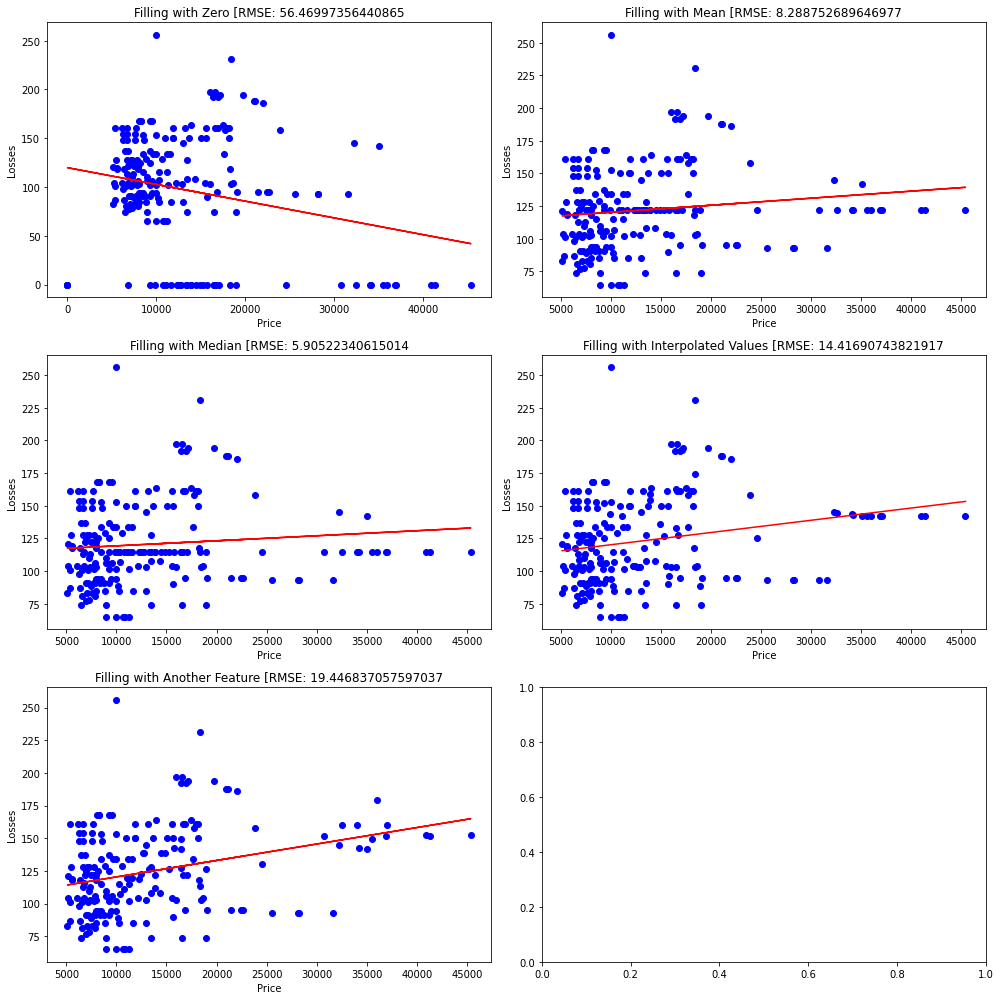

In [ ]:
# Create a scatter plot with the model from above (when NA replaced by 0) and 
# at least one other option.
figure, axes = plt.subplots(3, 2, figsize=(14,14))

data_dict = {"Zero": [rmse_0, X_0, y_0, slope_0, bias_0],
             "Mean": [rmse_av, X_av, y_av, slope_av, bias_av],
             "Median": [rmse_med, X_med, y_med, slope_med, bias_med],
             "Interpolated Values": [rmse_int, X_int, y_int, slope_int, bias_int],
             "Another Feature": [rmse_feat, X_feat, y_feat, slope_feat, bias_feat]}

data_list = list(data_dict.keys())
k = 0

for i in range(3):

  for j in range(2):
    if k >= len(data_list):
      break
      
    axes[i, j].set_xlabel("Price")
    axes[i, j].set_ylabel("Losses")

    approach = data_list[k]
    val = data_dict[approach]
    axes[i, j].set_title(f"Filling with {approach} [RMSE: {val[0]}")
    axes[i, j].scatter(val[1], val[2], c = "blue")
    axes[i, j].plot(val[1], (val[3] * val[1]) + val[4], c = "red")
    k += 1

figure.savefig("image1.jpg")
figure.tight_layout()

In [ ]:
"""
What option you think is best and why?

Observations:
1. There are many anomalies in the data
2. Data is mostly towards the left.

1st Approach: Replacing with the mean value
The mean of the data is again towards the left, so if we take the mean value, 
then the missing data will get values towards the center of the distribution, 
which is also a good approacch, but still it can be further improved with the 
median.

2nd Approach: Replacing with the median value
The median seemed to be the best option since the data is skewed right, as its
outliers or the tail seem to be on the right side. Therefore, the replacement by
median is the ideal choise to retain the data distribution. The RMSE was low - 
enough as compared to other methods

3rd Approach: Intepolating the values
The "losses" to be predicted are correlated with the "price". So the NaN values 
can also be filled using the interpolation technique. First, I sorted the data
based on the feature "price", and then interpolated the values for "losses" 
based on upper and lower values of "price". The RMSE was not quite good, 
because there were lot more missing data in between the values.

4th Approach: Filling with another feature
To fill out the NaN values, other features might also be helpful. We need to 
make sure that the feature we are considering has a good correlation score with
the label "losses". "Horsepower" was highly correlated as compared to "peak-rpm",
"city-mpg" and "highway-mpg". Therefore, I used the "horsepower" to calculate
the temp_slope and temp_bias and use those parameters to fill the NaN values
of "losses". After filling the NaN values, I run the polyfit method, to obtain 
the RMSE of approx 19. It didnot give much better result, because the correlation
score was not very high.

Conclusion:
In the scenario, the median produced better result since the data is skewed towards
right (tail on the right).


"""
